# Homework 1: Algorithmic Design - AA 2020/2021
## By: Andres Bermeo Marinelli


**Exercise 1:** Implement the strassen matrix multiplication function to multiply two $2^n x 2^n$ 
matrices by using the Strassen’s algorithm.

Solution: This method was implemented in class. We briefly describe its main aspects: 

1) The implementation makes use of the class *Matrix* which takes as input a list of lists and interprets it as a matrix. Aside from the expected operations a matrix must have, two important methods were implemented, namely *submatrix()* and *assign_submatrix()*, which respectively extract a submatrix from a matrix and assign a smaller submatrix to a matrix. 

2) The implementation further relies on an implementation of standard gauss multiplication which is invoked when the size of the problem is below a certain size (in our case the default value is for matrices smaller than 32x32). This is done because Strassen's algorithm introduces a lot of overhead/memory usage due to the creation of many auxiliary matrices, and for small problem sizes the Gauss implementation is faster. 


Below is a study of asymptotic behavior of the basic implementation.


In [57]:
from matrixclass import *                 # We import the matrix class
from strassengen_powpad import *          # strassengen_powpad and strassengen_evenpad implement a
from strassengen_evenpad import *         # generalized version of the algorithm. More is discussed later.
import numpy as np  
import matplotlib.pyplot as plt 
from random import random, seed
from timeit import timeit
from sys import stdout

seed(0)


We create random matrices of size $2^i \times 2^i \;\; \forall i \in \{0,...,10\}$ and multiply them together using the both the Strassen and the Gauss algorithm for comparison. We use the *timeit()* function to measure the execution time of both implementations. 

In [53]:
size = []
tgauss = []
tstrass = []
for i in range(11): #numbers from 0 to 10
        
        size.append(2**i)
        A = Matrix([[random() for x in range(size[i])] for y in range(size[i])])
        B = Matrix([[random() for x in range(size[i])] for y in range(size[i])])
        tgauss.append(timeit('gauss_matrix_mult(A,B)', globals=locals(), number=1))
        tstrass.append(timeit('strassen_matrix_mult(A,B)', globals=locals(), number=1))
        stdout.write(f'{size[i]}')
        stdout.write('\t{:.6f}'.format(tgauss[i]))
        stdout.write('\t{:.6f}'.format(tstrass[i]))
        stdout.flush()
        stdout.write('\n')
                    

1	0.000041	0.000017
2	0.000028	0.000019
4	0.000055	0.000047
8	0.000238	0.000213
16	0.001481	0.001441
32	0.010668	0.010785
64	0.086163	0.085818
128	0.705311	0.614139
256	5.360432	3.230757
512	26.910510	18.564627
1024	232.315248	132.148638


When interpreting the result above it is useful to remember that the Strassen implementation transforms automatically to a Gauss one for problems sizes less than or equal to $32 \times 32$ so the first six rows measure the execution time of the same algorithm. 

Looking at the results, we notice that already for a problem size $128 \times 128$, the Strassen implementation is $0.1$ seconds faster than the Gauss counterpart. The difference becomes more notable with $256 \times 256$ matrices, with an execution time of 3.57 seconds compared to 5.35 seconds for Gauss. Finally, for matrices of size $1024 \times 1024$ the Strassen implementation is circa $100$ seconds faster which is a considerable time saving. This result confirms the fact that the Strassen algorithm is indeed faster asymptotically than the Gauss counterpart.

Below we show the corresponding plot as an extra visual aid.

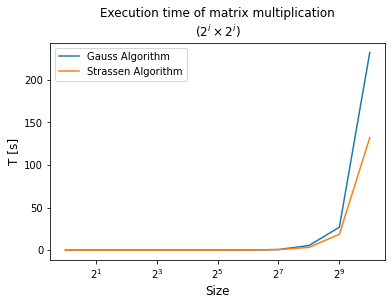

In [54]:
size = np.array(size)
plt.semilogx(size, tgauss, base = 2, label = 'Gauss Algorithm')
plt.semilogx(size, tstrass, base = 2, label = 'Strassen Algorithm')
plt.title('Execution time of matrix multiplication\n($2^i \\times 2^i$)')
plt.xlabel('Size', size = 12)
plt.ylabel('T [s]', size = 12)
plt.legend()
plt.savefig('GaussvsStrassenExectime.png')
plt.show()


**Exercise 2:** Generalize Strassen matrix multiplication to deal with any kind of matrix pair
that can be multiplied (possibly also non-square matrices) and prove that
the asymptotic complexity does not change.

Solution: To generalize the strassen implementation, I tried two different methods.

Method 1) Implemented in the module *strassengen_powerpad*. This implementation is based on "padding" the matrices in question with zeroes until they attain dimensions of the next power of two. In other words, given two matrices $A_{n\times m}$ and $B_{m \times k}$, we identify the maximum dimension $M = max\{n,m,k\}$ and compute the next power of two using $d=\lceil log_2(M)\rceil$. Then we create two matrices $2^d \times 2^d$ filled with zeroes and use *assign_submatrix()* to assign the old matrices to these new, much bigger matrices. Consquently, we call the old strassen implementation on the padded matrices and return a matrix without the padded zeroes using *submatrix()*. 

This method of generalization is very basic and, although surely correct, is definitely not the best since we use much more memory space than what is required by the problem. To illustrate this, consider two matrices $513 \times 513$, this implementation would enlarge the matrices to $1024 \times 1024$ padded with zeroes, which is quite inneficient. 

*Asymptotic analysis proof:* Consider two $n \times n$ matrices (not necessarily a power of 2). The asymptotic complexity of the Gauss algorithm will be $\theta (n^3)$. 
In the Strassen implementation described above, we pad the matrices with zeros to the next power of two, so we obtain two new matrices of size $2^{\lceil log_2(n)\rceil} \times 2^{\lceil log_2(n)\rceil}$. At this point, we apply the Strassen algorithm which has the standard recursion formula:


$ \theta (1) \: , \:  m=1$

$7T(\frac{m}{2})+\theta \bigg( (\frac{m}{2})^2 \bigg)  \: , \: m>1$


Where $m$ is the problem size. Applying the results found in class, we know that the complexity (not considering constants) is:

$m^{log_2 7} = 2^{\big \lceil log_2(n)\big\rceil\, log_2 7} < 2^{(\,log_2(n)+2\,)\, log_2 7} = c \cdot 2^{log_2 n \; log_2 7}= c \cdot n^{log_2 7}$

Where we used the fact that $\lceil log_2(x)\big\rceil\ < log_2(x) + 2 \;\; \forall \, x \,\in R $ .

Since we are not interested in the constants, this is still $\theta (n^{log_2 7})$.

Method 2) Implemented in the module *strassgen_evenpad*. This smarter implementation is based on padding with zeroes to the next even dimension. An example is better suited to explain: Consider two matrices with dimension $5 \times 5$ and $5 \times 7$, these are padded with zeroes to dimensions $6 \times 6$ and $6 \times 8$. The algorithm still works correctly since the four subquadrants are obtained as before and in the recursive calls the sizes are still compliant with the rules of matrix multiplication. However one must be careful to return the correct size (the one before before padding) otherwise the algorithm will not work due to dimensional inconsistencies.

We expect this method to be much more effective since we pads with zeroes in a minimal way.

*Asymptotic analysis proof:* The proof follows from the case above since padding to a power of 2 results in a bigger sized problem for which we showed that the complexity is still $\theta (n^{log_2 7})$.




Below we show a few examples of matrix multiplications (chosen randomly) in order to show some evidence of correctness of these algorithms. 

In [47]:

def matrix_mult(Arows: int, Acols: int, Bcols: int) -> None:
    '''Input: Dimensions of A and B (cols A = rows B for multiplication to be allowed).
    Output: Creates random matrices and prints the gauss multiplication, the Strassen power pad multiplication
    and the Strassen even pad multiplication. It also prints the difference between the Gauss method and the other two methods. '''

    print('Multiplying matrices of size: \n')
    print('\t\t\t\t\t', Arows, ' x ', Acols, 'and' , Acols, ' x ', Bcols)
    A = Matrix([[random() for x in range(Acols)] for y in range(Arows)])
    B = Matrix([[random() for x in range(Bcols)] for y in range(Acols)])

    print('Strassen Power Pad Method \n')
    SP = strassen_gen_powerpad(A,B,0,2) 
    print(SP,'\n')                      
    print('Strassen Even Pad Method \n')
    SE = strassen_gen_evenpad(A,B,2)
    print(SE, '\n')
    print('Gauss Implementation \n')
    G =gauss_matrix_mult(A,B)
    print(G, '\n')
    print('Difference Gauss and Strassen Power Method \n (Expect machine precision) \n')
    print( G-SP, '\n')
    print('Difference Gauss and Strassen Even Method \n (Expect machine precision) \n')
    print('\n', G-SE)


                                        


In [35]:
#Dims of A and B chosen randomly, contained to 10 for visibility of results.
Arows = int(np.ceil(np.random.rand()*10))
Acols = int(np.ceil(np.random.rand()*10))
Bcols = int(np.ceil(np.random.rand()*10))

matrix_mult(Arows,Acols,Bcols)

Multiplying matrices of size: 

					 4  x  6 and 6  x  5
Strassen Power Pad Method 

[0.9874101348639932, 1.7467998068467674, 1.5062838161601486, 1.6638625739026942, 1.191813692375578]
[1.068942492912917, 1.8660735337334429, 1.5504377797388067, 1.6702040549759176, 1.1098423340755472]
[1.0121689754605137, 1.843392866177672, 1.1268786033668463, 1.8190071158084418, 1.5663224553566715]
[1.1964266786117772, 1.9529913795728742, 1.4562246206448712, 2.0976343755906957, 1.7157482172968053] 

Strassen Even Pad Method 

[0.9874101348639938, 1.7467998068467672, 1.5062838161601488, 1.6638625739026944, 1.1918136923755778]
[1.068942492912917, 1.8660735337334429, 1.5504377797388063, 1.6702040549759176, 1.1098423340755474]
[1.0121689754605137, 1.8433928661776708, 1.1268786033668465, 1.8190071158084418, 1.566322455356672]
[1.1964266786117772, 1.9529913795728748, 1.456224620644871, 2.0976343755906957, 1.715748217296805] 

Gauss Implementation 

[0.9874101348639932, 1.746799806846767, 1.5062838161601486,

In [37]:
Arows = int(np.ceil(np.random.rand()*10))
Acols = int(np.ceil(np.random.rand()*10))
Bcols = int(np.ceil(np.random.rand()*10))

matrix_mult(Arows,Acols,Bcols)

Multiplying matrices of size: 

					 2  x  4 and 4  x  5
Strassen Power Pad Method 

[0.8553408542696126, 1.2020231578355693, 1.8375335793378706, 1.5675582068945166, 1.0238751150785717]
[1.5429019096025278, 1.7394525309823077, 2.2043051923463852, 1.7747767893299107, 1.2932014684992788] 

Strassen Even Pad Method 

[0.8553408542696128, 1.2020231578355691, 1.8375335793378706, 1.5675582068945166, 1.0238751150785717]
[1.5429019096025278, 1.739452530982308, 2.2043051923463852, 1.7747767893299111, 1.293201468499278] 

Gauss Implementation 

[0.8553408542696123, 1.2020231578355696, 1.8375335793378709, 1.5675582068945164, 1.0238751150785717]
[1.5429019096025283, 1.739452530982308, 2.2043051923463852, 1.7747767893299105, 1.2932014684992788] 

Difference Gauss and Strassen Power Method 
 (Expect machine precision) 

[-3.3306690738754696e-16, 2.220446049250313e-16, 2.220446049250313e-16, -2.220446049250313e-16, 0.0]
[4.440892098500626e-16, 2.220446049250313e-16, 0.0, -2.220446049250313e-16, 0.0]

In [40]:
Arows = int(np.ceil(np.random.rand()*10))
Acols = int(np.ceil(np.random.rand()*10))
Bcols = int(np.ceil(np.random.rand()*10))

matrix_mult(Arows,Acols,Bcols)

Multiplying matrices of size: 

					 9  x  7 and 7  x  4
Strassen Power Pad Method 

[2.1305304877672504, 3.6119559031519324, 2.27550232764425, 2.098934405896101]
[1.5633760281376017, 1.5722503700967678, 1.7750988933014682, 1.5064142794584683]
[1.3637252027852669, 1.8512099238720519, 1.9745484279997856, 1.55496218715329]
[1.1110231444013903, 1.839709485932975, 1.5501369204634892, 1.003565771678769]
[1.7977365150009832, 3.173363967361335, 2.3021056917064047, 1.8754745314837789]
[1.2190271971136988, 1.6296262222964355, 1.184699683344495, 0.7942582154894401]
[1.0662407237472322, 2.111633838566893, 1.249651986533674, 0.9595193538451653]
[1.3369631260371402, 2.0581602555355865, 1.5508713138404677, 1.4180294587493538]
[1.1896409258276102, 1.7266393498744281, 1.348743361134952, 1.2287140081527095] 

Strassen Even Pad Method 

[2.13053048776725, 3.6119559031519315, 2.27550232764425, 2.0989344058961006]
[1.563376028137601, 1.5722503700967678, 1.7750988933014678, 1.5064142794584678]
[1.36372520

From these examples we can see that the implementations seem to work correctly.


**Exercise 3:** Improve the implementation of the function by reducing the number of
auxiliary matrices and test the effects on the execution time.

Solution: In order to reduce the number of auxilary matrices we make an observation.

1) Matrices $S_i$, $i \in \{1,...10\}$ are defined by the quadrants of A and B. 

2) Matrices $P_i$, $i \in \{1,...,7\}$ can directly incorporate the definition of $S_i$, $i \in \{1,...10\}$ without allocating unecessary space. 

3) Matrices $C_{i,j}$, $i,j \in \{1,2\}\times \{1,2\}$ are linear combinations of $P_i$, $i \in \{1,...,7\}$. Since we use the *assign_submatrix()* method to assign $C_{i,j}$ into the original matrix, we can directly incorporate the definition of $P_i$ in the function without allocating new memory.

These three observations are the basis for what we will refer to as "version 2 optimization" or "O-2".

Another type of optimization was attempted based on the following additional observation:

1) Using the same considerations as above, we can further implement an *add_submatrix()* method which adds a submatrix to an existing matrix instead of assigning it. Using this method, we can allocate space for a single matrix $P$.

This matrix initially is the definition of $P_1$, and is added/subtracted to the quadrants where it is needed. Then, P is changed to the definition of $P_2$ and added/subtracted to the appropriate quadrants. In this way we only need to allocate space for one single matrix instead of 7 which saves memory. However on the other hand, we call a method 8 additional times compared to before and this could prove more costly than the memory saved for small problem sizes. However,for bigger problems, the memory savings should dominate over the cost of 8 extra function calls.  

This type of optimization is what we will refer to as "version 1 optimization" or "O-1".


Below we show the execution times of all six algorithms.

1) Naive Gauss implementation.

2) Strassen generalized power padding implementation with no optimization.

3) Strassen generalized power padidng implementation with version 1 optimization.

4) Strassen generalized power padding implementation with version 2 optimization.

5) Strassen generalized even padding implementation with no optimization.

6) Strassen generalized even padding implementation with version 1 optimization.

7) Strassen generalized even padding implementation with version 2 optimization.

In order to test the effect of our padding and see if our implementations are still valid and practical in a general setting, we work with matrices of size $3^i \times 3^i$. This is because if we were to use matrices of size $2^i \times 2^i$, no padding would be done and we would fall back to the initial case. It is more interesting instead to test what the padding implies for the algorithm itself and its practicality.


In [46]:
size = []
tgauss = []
tstrass_gen_even = []
tstrass_optm_even = []
tstrass_optm2_even = []
tstrass_gen_pow = []
tstrass_optm_pow = []
tstrass_optm2_pow = []


for i in range(8): #numbers from 0 to 7
        
        size.append(3**i)
        A = Matrix([[random() for x in range(size[i])] for y in range(size[i])])
        B = Matrix([[random() for x in range(size[i])] for y in range(size[i])])
        tgauss.append(timeit('gauss_matrix_mult(A,B)', globals=locals(), number=1))
        tstrass_gen_even.append(timeit('strassen_gen_evenpad(A, B)', globals=locals(), number=1))
        tstrass_optm_even.append(timeit('strassen_optimized_evenpad(A, B)', globals=locals(), number=1))
        tstrass_optm2_even.append(timeit('strassen_optimized2_evenpad(A, B)', globals=locals(), number=1))

        tstrass_gen_pow.append(timeit('strassen_gen_powerpad(A, B, 0)', globals=locals(), number=1))
        tstrass_optm_pow.append(timeit('strassen_gen_powerpad(A, B, 1)', globals=locals(), number=1))
        tstrass_optm2_pow.append(timeit('strassen_gen_powerpad(A, B, 2)', globals=locals(), number=1))

        
        stdout.write(f'{size[i]}')
        stdout.write('\t{:.6f}'.format(tgauss[i]))
        stdout.write('\t{:.6f}'.format(tstrass_gen_even[i]))
        stdout.write('\t{:.6f}'.format(tstrass_optm_even[i]))
        stdout.write('\t{:.6f}'.format(tstrass_optm2_even[i]))
        stdout.write('\t{:.6f}'.format(tstrass_gen_pow[i]))
        stdout.write('\t{:.6f}'.format(tstrass_optm_pow[i]))
        stdout.write('\t{:.6f}'.format(tstrass_optm2_pow[i]))
        stdout.flush()
        stdout.write('\n')

#size   gauss        even pad        even O1         even O2        power pad       pow. pad O1    pow. pad O2  

1	0.000026	0.000017	0.000013	0.000013	0.000064	0.000030	0.000028
3	0.000056	0.000031	0.000028	0.000027	0.000100	0.000071	0.000087
9	0.000383	0.000292	0.000307	0.000289	0.001698	0.001650	0.001645
27	0.006593	0.006440	0.008360	0.006481	0.011762	0.011769	0.011682
81	0.173095	0.205982	0.196300	0.201597	0.633643	0.617346	0.628275
243	4.587075	3.176403	2.345083	2.440735	2.624209	2.653801	2.704997
729	79.970675	54.635225	51.876670	54.580590	135.826623	130.940940	135.481838
2187	2425.010621	1493.460808	1374.050757	1492.221499	6746.337186	6452.430120	6717.324582


Looking at the results, we notice that the gauss implementation is faster than all the power pad method and its optimizations. This doesn't mean that the method is wrong but rather that we still haven't reached the problem size for which the asymptotic conditions are satisfied. Thus, this method isn't practical for multiplying matrices in real applications since we probably need to increase the size by a lot before we see any benefits. 

On the other hand, we notice that the even pad implementation and its optimized versions are faster than the Gauss method already for matrices of size $243 \times 243$ and above. We also observe that between the two optimizations, version O-1 is clearly the faster one (also true in the case of power pad). As mentioned earlier, this is probably due to the fact that it allocates only one matrix at each iteration instead of 7 different ones. 

We conclude that the fastest method is the even pad with O-1 optimization which, for a problem size of $2187 \times 2187$ is around $1000$ seconds faster than the Gauss implementation. 

Below we present the plots as an extra visual aid.

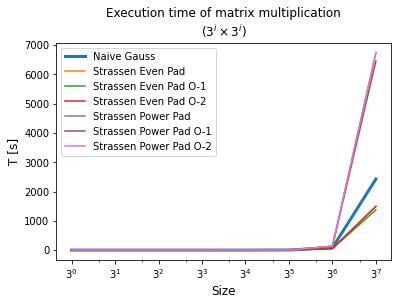

In [60]:
#Since the run was time consuming I saved the numbers by hand as extra precaution.
size = [1,2,9,27,81,243,729,2187]
tgauss = [0.000026,0.000056,0.000383,0.006593,0.173095,4.587075,79.970675,2425.010621]
tstrass_gen_even = [0.000017,0.000031,0.000292,0.006440,0.205982,3.176403,54.635225,1493.460808]
tstrass_optm_even = [0.000013,0.000028,0.000307,0.008360,0.196300,2.345083,51.876670,1374.050757]
tstrass_optm2_even = [0.000013,0.000027,0.000289,0.006481,0.201597,2.440735,54.580590,1492.221499]
tstrass_gen_pow = [0.000064,0.000100,0.001698,0.011762,0.633643,2.624209,135.826623,6746.337186]
tstrass_optm_pow = [0.000030,0.000071,0.001650,0.011769,0.617346,2.653801,130.940940,6452.430120]
tstrass_optm2_pow = [0.000028,0.000087,0.001645,0.011682,0.628275,2.704997,135.481838,6717.324582]


size = np.array(size)
plt.semilogx(size, tgauss, base = 3, label = 'Naive Gauss', lw = 3)
plt.semilogx(size, tstrass_gen_even, base = 3, label = 'Strassen Even Pad')
plt.semilogx(size, tstrass_optm_even, base = 3, label = 'Strassen Even Pad O-1')
plt.semilogx(size, tstrass_optm2_even, base = 3, label = 'Strassen Even Pad O-2')
plt.semilogx(size, tstrass_gen_pow, base = 3, label = 'Strassen Power Pad')
plt.semilogx(size, tstrass_optm_pow, base = 3, label = 'Strassen Power Pad O-1')
plt.semilogx(size, tstrass_optm2_pow, base = 3, label = 'Strassen Power Pad O-2')

plt.title('Execution time of matrix multiplication\n($3^i \\times 3^i$)')
plt.xlabel('Size', size = 12)
plt.ylabel('T [s]', size = 12)
plt.legend()
plt.savefig('GaussvsStrassenExecTimeGeneralCase.png')
plt.show()

**Exercise 4:** How much is the minimum auxiliary space required to evaluate the Strassen’s algorithm? Motivate the answer.

The optimized O-1 version is the one that employs the least amount of space. At each iteration, we allocate space for the 8 subquadrants of A and B (each of size $\frac{n}{2} \times \frac{n}{2}$) and one matrix which will be the result matrix (size $n \times n$). Then we allocate only one matrix for the recursive calls (with a problem that is halved).

Thus, the recursion formula for the minimum space needed is:

$\theta(1) \;\;, \; n=1$

$T(\frac{n}{2}) + \theta\bigg(8\cdot(\frac{n}{2})^2\bigg)+\theta(n^2)=T(\frac{n}{2}) + \theta\big(n^2\big) \;\;, \; n>1$

This corresponds to a complexity $\theta(n^2)$ which is the minimum space needed for Strassen's algorithm.

